## Lab - 4

Name: Purusharth Malik

Registration No.: 2348542

### Implement fine-tuning procedures on BERT for sentiment analysis.

In [27]:
from datasets import load_dataset
data = load_dataset('imdb')

In [46]:
import torchtext
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer

torchtext.disable_torchtext_deprecation_warning()

# Loading the data
training_data = data['train']
test_data = data['test']

# Creating a Dataset class
class IMDBDataset(Dataset):
    def __init__(self, data, train):
        self.train = train
        # Initializing the tokenizer
        tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
        if train:
            self.tokens = tokenizer(list(training_data['text']), 
                                          padding=True,
                                          truncation=True)
            self.labels = training_data['label']
        else:
            self.tokens = tokenizer(list(test_data['text']),
                                         padding=True,
                                         truncation=True)
            self.labels = test_data['label']
    
    def __len__(self):
        return len(training_data['text']) if self.train else len(test_data['text'])
    
    def __getitem__(self, idx):
        sample = {}
        # Adding the input_ids, token_type_ids, and attention masks to the samples
        for k, v in self.tokens.items():
            sample[k] = torch.tensor(v[idx])
        sample['label'] = torch.tensor(self.labels[idx])
        return sample
    
# Creating the datasets
train_dataset = IMDBDataset(training_data, train=True)
test_dataset = IMDBDataset(test_data, train=False)

# Creating the dataloaders
train_dataloader = DataLoader(train_dataset,
                              batch_size=32,
                              shuffle=True)
test_dataloader = DataLoader(test_dataset,
                             batch_size=32,
                             shuffle=False)

In [48]:
# Looking at a sample batch
next(iter(train_dataloader))

{'input_ids': tensor([[  101,  1045,  3473,  ...,     0,     0,     0],
         [  101,  2054,  2001,  ...,     0,     0,     0],
         [  101,  1996, 18988,  ...,     0,     0,     0],
         ...,
         [  101,  2834,  1029,  ...,     0,     0,     0],
         [  101,  6754,  4482,  ...,     0,     0,     0],
         [  101,  2023,  2969,  ...,     0,     0,     0]]),
 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]),
 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 'label': tensor([1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1,
         0, 1, 0, 0, 1, 1, 0, 0])}

In [1]:
import torch
from transformers import BertForSequenceClassification

# Loading the BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [2]:
# Looking at the model
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

- Fine Tuning

    We will be using PEFT to train a fraction of the Bert classifier. We will also make use of mixed precision in order to train the model quickly.

In [ ]:
import torch
from transformers import BertForSequenceClassification, get_linear_schedule_with_warmup
from peft import get_peft_model, LoraConfig, TaskType
from torch.optim import AdamW
from tqdm.auto import tqdm
from torch.cuda.amp import autocast, GradScaler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Configuring LoRA
peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=8,
    lora_alpha=32,
    lora_dropout=0.1,
    bias="none",
    target_modules=["query", "key", "value", "output.dense"]
)

# Wrapping the model
model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

# Moving the model to the GPU
model.to(device)

# Initializing GradScaler
scaler = GradScaler()

num_epochs = 3
total_steps = num_epochs * len(train_dataloader)

# Initializing the optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

# Learning rate scheduler
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=len(train_dataloader) * num_epochs
)

# Configuring the loss function
criterion = torch.nn.CrossEntropyLoss()

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    
    progress_bar = tqdm(train_dataloader, desc=f"Epoch: {epoch+1}/{num_epochs}")
    
    for batch in progress_bar:
        batch = {k: v.to(device) for k, v in batch.items()}
        
        optimizer.zero_grad()
        
        # Use autocast for mixed precision
        with autocast():
            output = model(batch['input_ids'],
                           attention_mask=batch['attention_mask'])
            
            pred = output.logits
            loss = criterion(pred, batch['label'])
        
        # Scale the loss and call backward
        scaler.scale(loss).backward()
        
        # Unscale the gradients, clip them, and update the parameters
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()
        
        scheduler.step()
        
        total_loss += loss.item()
        
        # Update progress bar with current loss
        progress_bar.set_postfix({'Loss': f"{loss.item():.4f}"})

    # Print average loss for the epoch
    avg_loss = total_loss / len(train_dataloader)
    print(f"Average loss for epoch {epoch+1}: {avg_loss:.4f}")

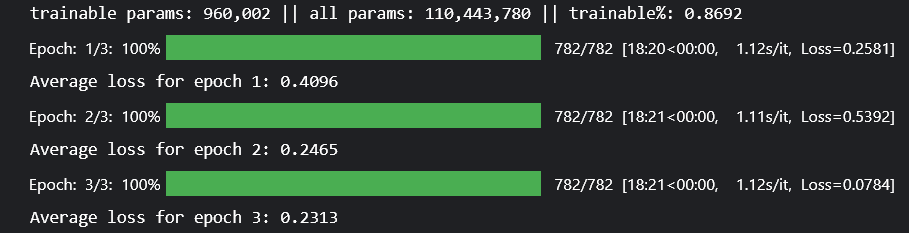

We will now write an evaluation loop,

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    # Disabling the gradient calculation
    with torch.no_grad():
        # Writing the evaluation loop
        for batch in tqdm(dataloader, desc="Evaluating"):
            batch = {k: v.to(device) for k, v in batch.items()}
            
            # Inferencing the model
            outputs = model(batch['input_ids'], attention_mask=batch['attention_mask'])
            logits = outputs.logits
            
            # Calculating the loss
            loss = criterion(logits, batch['label'])
            total_loss += loss.item()
            
            # Making the predictions
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch['label'].cpu().numpy())
    
    # Calculate average loss
    avg_loss = total_loss / len(dataloader)
    
    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
    
    return {
        'loss': avg_loss,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

# Assuming you have a validation dataloader called val_dataloader
val_results = evaluate(model, test_dataloader, criterion, device)

print("Validation Results:")
for metric, value in val_results.items():
    print(f"{metric.capitalize()}: {value:.4f}")

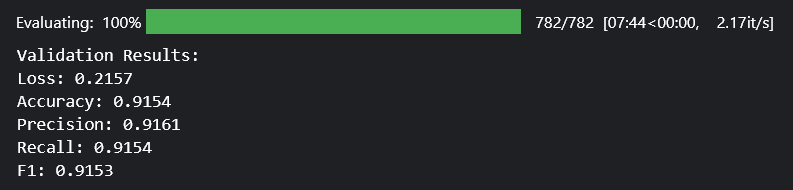

In [ ]:
text = "Some people are good at being bad."

# Tokenizing the text
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased",
                                          return_tensors='pt')
tokens = tokenizer(text)

with torch.no_grad():
    # Sending the input_ids and attention_mask to the GPU
    input_ids = torch.tensor(tokens['input_ids']).unsqueeze(0).to(device)
    attention_mask = torch.tensor(tokens['attention_mask']).unsqueeze(0).to(device)

    # Making the predictions
    outputs = model(input_ids, attention_mask=attention_mask)
    logits = outputs.logits
    probabilities = torch.softmax(logits, dim=1)
    predicted_class = torch.argmax(probabilities, dim=1).item()

sentiment_map = {0: "Negative", 1: "Neutral", 2: "Positive"}
sentiment = sentiment_map[predicted_class]
confidence = probabilities[0][predicted_class].item()
print(f"Sentiment: {sentiment}\nConfidence: {confidence:.4f}")

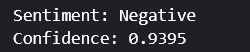

# End